# Predicting Customer's Favorite Dish using XGBoost
This notebook implements a machine learning model to predict a customer's favorite dish based on dining preferences.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import openpyxl

## Load Dataset

In [3]:
dining_df = pd.read_excel("/content/dining_info.xlsx")
dining_df['order_time'] = pd.to_datetime(dining_df['order_time'])
dining_df.head()

,Unnamed: 0,transaction_id,customer_id,Preferred Cusine,age,dish,Qty,price_for_1,number_of_stayers,check_in_date,check_out_date,order_time,booked_through_points
0,0,3594217,91,South Indian,31,Filter Coffee,2,80,1,2023-08-07,2023-08-10 18:33:11,2023-08-09 03:40:45,0
1,1,10163344,92,South Indian,21,Chocolate Cake,2,200,2,2023-08-08,2023-08-10 04:10:06,2023-08-08 19:20:37,0
2,2,12292432,93,North Indian,48,Breakfast thali,1,500,2,2023-11-15,2023-11-17 08:21:37,2023-11-15 14:01:51,1
3,3,13757710,94,South Indian,25,Roti Curry,3,100,3,2024-03-31,2024-04-03 09:35:00,2024-03-31 11:17:37,0
4,4,10762656,95,North Indian,22,Filter Coffee,1,80,1,2024-04-08,2024-04-11 02:22:57,2024-04-10 23:00:56,0


## Split Dataset Based on Order Time

In [4]:
features_df = dining_df[dining_df['order_time'] < '2024-01-01']
train_df = dining_df[(dining_df['order_time'] >= '2024-01-01') & (dining_df['order_time'] < '2024-10-01')]
test_df = dining_df[dining_df['order_time'] >= '2024-10-01']

## Feature Engineering

In [5]:
customer_features = features_df.groupby('customer_id').agg(
    total_orders_per_customer=('transaction_id', 'count'),
    avg_spend_per_customer=('price_for_1', 'mean'),
    total_qty_per_customer=('Qty', 'sum')
).reset_index()

cuisine_features = features_df.groupby('Preferred Cusine').agg(
    avg_price_per_cuisine=('price_for_1', 'mean'),
    total_orders_per_cuisine=('transaction_id', 'count')
).reset_index()

## Merge Features with Train and Test Data

In [6]:
train_df = train_df.merge(customer_features, on='customer_id', how='left')
train_df = train_df.merge(cuisine_features, on='Preferred Cusine', how='left')
test_df = test_df.merge(customer_features, on='customer_id', how='left')
test_df = test_df.merge(cuisine_features, on='Preferred Cusine', how='left')

## Drop Unnecessary Columns

In [7]:
cols_to_drop = ['transaction_id', 'customer_id', 'price_for_1', 'order_time', 'Qty']
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

## Encoding Categorical Features

In [8]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_cols = ['Preferred Cusine']
train_encoded = encoder.fit_transform(train_df[categorical_cols])
test_encoded = encoder.transform(test_df[categorical_cols])
train_df = pd.concat([train_df.drop(columns=categorical_cols), pd.DataFrame(train_encoded)], axis=1)
test_df = pd.concat([test_df.drop(columns=categorical_cols), pd.DataFrame(test_encoded)], axis=1)

## Encoding Target Variable

In [9]:
label_encoder = LabelEncoder()
train_df['dish'] = label_encoder.fit_transform(train_df['dish'])
test_df['dish'] = label_encoder.transform(test_df['dish'])

## Split Features and Target

In [10]:
X_train = train_df.drop(columns=['dish'])
y_train = train_df['dish']
X_test = test_df.drop(columns=['dish'])
y_test = test_df['dish']

## Train XGBoost Model

In [11]:
for col in ['check_in_date', 'check_out_date']:
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = pd.to_numeric(X_test[col])
model = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', learning_rate=0.1, max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

## Make Predictions and Evaluate Model

In [12]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
print(f'Accuracy: {accuracy:.4f}')
print(f'Log Loss: {logloss:.4f}')

Accuracy: 0.0689
Log Loss: 2.7858


##Feature Analysis

In [14]:
feature_importance = model.feature_importances_ # Changed xgb_model to model
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
5       booked_through_points    0.506590
3               check_in_date    0.058514
4              check_out_date    0.055430
6   total_orders_per_customer    0.054889
9       avg_price_per_cuisine    0.052374
0                  Unnamed: 0    0.048161
7      avg_spend_per_customer    0.047037
10   total_orders_per_cuisine    0.046366
1                         age    0.045198
8      total_qty_per_customer    0.043108
2           number_of_stayers    0.042332
11                          0    0.000000
12                          1    0.000000
13                          2    0.000000


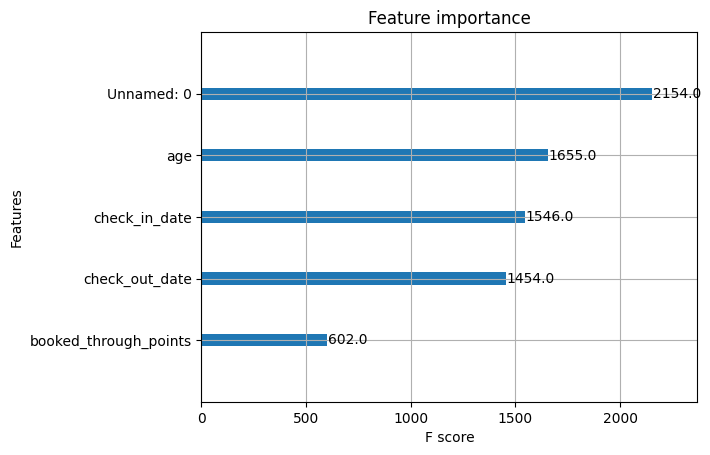

In [17]:
import xgboost as xgb # Import the xgboost library as xgb
import matplotlib.pyplot as plt # Import the plotting library
model = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', learning_rate=0.1, max_depth=3, n_estimators=100) # Initialize the model using xgb
model.fit(X_train, y_train)
xgb.plot_importance(model, max_num_features=5) # Use xgb for plotting and pass the model variable
plt.show()